In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib 
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import pytorch_lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn.functional as F
torch.manual_seed(40)
import pdb
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import glob
import os.path
import hashlib
import cv2
import re
import math

In [2]:
all_chars = " -.ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvwxyz¶"
print(len(all_chars))
char_to_num = {}
num_to_char = {}
for i in range(len(all_chars)):
    num_to_char[i+1] = all_chars[i]
    char_to_num[all_chars[i]] = i+1
    
PAD_ID = 0
START_ID = len(all_chars) + 1
END_ID = len(all_chars) + 2
NUM_IDs = len(all_chars) + 3 #chars
MAX_LEN = 250

55


In [3]:
class LineImageDataset(Dataset):
    def classify(self, line_im_filename):
        str_hash = hashlib.md5(line_im_filename.encode()).hexdigest()
        hash_num = int(str_hash[:8], 16) % 100 #"random" num between 0 and 99
        if hash_num < 90: return "train"
        else: return "val"
    
    def get_namespace(self, element):
        #rint(element.tag)
        m = re.match('\{.*\}', element.tag)
        return m.group(0)[1:-1] if m else ''    
    
    def process_image(self, image, block_width=32):
        assert(image.ndim == 2)
        height, width = image.shape
        
        #First, pad so width is multiple of block_width
        remainder = width % block_width
        padding = block_width - remainder
        padded_image = F.pad(image, (0, padding, 0, 0))
        padded_width = width + padding
       
        #Now reshape the image into vectors of length height x block_width
        reshaped = padded_image.transpose(1,0).reshape(-1, height*block_width).T
        return reshaped
    
    def __init__(self, dirname, char_to_num, num_to_char, data_type, transform=None, test=False):
        self.transform = transform       
        self.char_to_num = char_to_num
        self.num_to_char = num_to_char
        self.data_type = data_type
        self.line_images = []
        #self.processed_line_images = []
        self.image_filenames = []
        self.line_image_filenames = []
        self.labels = []
        self.num_labels = []
        
        for filename in sorted(glob.glob(dirname + "/*.xml")):
            #print(filename)
            tree = ET.parse(filename)
            root = tree.getroot()
            ns = {"ns": self.get_namespace(tree.getroot())}
            ET.register_namespace('', ns['ns'])
            
            image_filename = root.find('ns:Page', ns).get('imageFilename')

            #First iteration: calculate average line spacing
            for text_region in root.findall('.//ns:TextRegion', ns):
                for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):                    
                    line_im_filename = dirname + "/line_{}_{}".format(lineno, image_filename)
                    line_im_filename, _ = os.path.splitext(line_im_filename)
                    line_im_filename += ".png"
                    if data_type != "all" and self.classify(line_im_filename) != data_type:
                        continue
                    self.image_filenames.append(image_filename)
                    self.line_image_filenames.append(line_im_filename)
                    #print(
                    #self.line_images.append(read_image(line_im_filename, ImageReadMode.GRAY).float())
                    self.line_images.append(torch.tensor(np.load(line_im_filename.replace(".png", ".npy")), dtype=torch.float32).unsqueeze(0))
                    #self.processed_line_images.append(self.process_image(self.line_images[-1].squeeze()).unsqueeze(0).unsqueeze(0))
                                                      
                    if test: text = ""
                    else:
                        text = text_line.find('.//ns:TextEquiv', ns).find('.//ns:Unicode', ns).text     
                        text = text.strip()
                        text = text.replace(",", ".")
                        if ";" in text:
                            print(image_filename, text)
                    
                    self.labels.append(text)
                    
                    self.num_labels.append(torch.tensor(
                        [START_ID] + [self.char_to_num[c] for c in text] + [END_ID]))

                                        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):                
        image = self.line_images[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        processed_image = self.process_image(image.squeeze()).unsqueeze(0)
       
        return {"image": image, "processed_image": processed_image, "target": self.num_labels[idx], "text": self.labels[idx]}


In [4]:
train_transform = transforms.Compose(
    [
       transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
       transforms.RandomAffine(0.7, translate=(0.01, 0.02), scale=(0.98, 1.02)),
       transforms.RandomChoice([
            transforms.RandomAdjustSharpness(2, p=0.5),
            transforms.GaussianBlur(21, (1,6))
        ]),    
        transforms.Normalize(0.15, 0.38)
    ])

val_transform = transforms.Compose(
    [  
        transforms.Normalize(0.15, 0.38)
    ])

In [5]:
dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=val_transform)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_indices, val_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, val_size])

train_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=train_transform)
val_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="all", transform=val_transform)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

In [6]:
class PositionalEncoding(nn.Module):
    # https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(MAX_LEN).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, MAX_LEN, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [7]:
#Only batch sizes of 1 currently supported
class MyTransformer(nn.Module):
    def __init__(self, block_size, dropout=0.1, d_model=352):
        #block_size: number of pixels per block (default 4096)
        super().__init__()        
        self.d_model = d_model
        self.linear_input = nn.Linear(block_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model=d_model, dropout=dropout)
        
        self.transformer = torch.nn.Transformer(
            d_model=d_model,
            nhead=4,
            num_encoder_layers=4,
            num_decoder_layers=4,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )
        self.block_size = block_size
        self.embedding = nn.Embedding(NUM_IDs, d_model)
        self.linear_output = nn.Linear(d_model, NUM_IDs)
        
    def encode_src(self, src):
        src = self.linear_input(src)     
        src = self.pos_encoder(src)
        src = self.transformer.encoder(src)
        return src

    def decode_trg(self, trg, memory):
        batch_size, seq_len = trg.size(0), trg.size(1)
        assert(batch_size == 1)
        trg_pad_mask = (trg == PAD_ID)
        trg = self.embedding(trg.long()) * math.sqrt(self.d_model)
        trg = self.pos_encoder(trg)
        
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=bool, device=trg.device) * True, diagonal=1)
        out = self.transformer.decoder(
            tgt=trg, memory=memory, tgt_mask=causal_mask, tgt_key_padding_mask=trg_pad_mask,
            tgt_is_causal=True
        )
        out = self.linear_output(out)
        return out
        
        
    def forward(self, src, trg):
        encoded_src = self.encode_src(src)
        out = self.decode_trg(trg=trg, memory=encoded_src)
        return out

In [8]:
net = MyTransformer(4096, dropout=0.1)
src = torch.rand((1,250,4096))
trg = torch.randint(0, 10, (1,250))
print(net(src, trg))

tensor([[[ 0.5684, -0.7048,  0.0447,  ..., -0.4983,  0.3997, -0.0914],
         [-0.0251, -0.8893, -0.0837,  ...,  0.2626,  0.1835,  0.7136],
         [ 0.5134, -0.9856, -0.0963,  ...,  0.1951,  0.0208, -0.4206],
         ...,
         [ 0.1900, -0.4408,  1.0036,  ..., -0.0379,  0.6769, -0.4856],
         [ 0.2327, -0.4801,  0.7552,  ...,  0.5962,  0.6460,  0.4282],
         [ 0.2292, -0.7480, -0.0902,  ...,  0.1344,  0.5567,  0.1515]]],
       grad_fn=<ViewBackward0>)


In [9]:
class LatinTranscriber(L.LightningModule):
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def _get_current_lr(self):
        for param_group in self.trainer.optimizers[0].param_groups:
            return param_group['lr']
        
    def on_train_epoch_end(self):
        lr = self._get_current_lr()
        self.log('lr-Adam', lr)

    def training_step(self, batch, batch_idx):
        assert self.net.training
        loss, output = self.get_loss(batch, batch_idx, "train")
        return loss
    
    
    def get_logger(self):
        tb_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, pl_loggers.TensorBoardLogger):
                tb_logger = logger.experiment
                break
        return tb_logger
        
    
    def validation_step(self, batch, batch_idx):
        assert not self.net.training
        assert batch["target"].shape[0] == 1
        loss, output = self.get_loss(batch, batch_idx, "val")

        if batch_idx < 16:
            prediction = self.get_prediction(batch["processed_image"])
            target = batch["target"][0]
            truth = ''.join([num_to_char[t.item()] for t in target[1:-1]])
            tb_logger = self.get_logger()
            tb_logger.add_image(f'Validation #{batch_idx}, target: {truth}', batch['image'][0], self.global_step, dataformats="CHW")
            tb_logger.add_text(f'Validation #{batch_idx}, target: {truth}', prediction, self.global_step)
        
        return loss
    
    def masked_accuracy(self, y_true: torch.Tensor, y_pred: torch.Tensor):
        mask = y_true != PAD_ID
        y_true = torch.masked_select(y_true, mask)
        y_pred = torch.masked_select(y_pred, mask)
        acc = (y_true == y_pred).double().mean()
        return acc


    def get_loss(self, batch, batch_idx, name):
        src = batch["processed_image"].squeeze(1).transpose(1,2)
        trg = batch["target"]

        trg_in, trg_out = trg[:, :-1], trg[:, 1:]
        y_hat_orig = self.net(src, trg_in)
        y_hat = y_hat_orig.view(-1, y_hat_orig.size(2))
        y = trg_out.contiguous().view(-1)
        loss = F.cross_entropy(y_hat, y, ignore_index=PAD_ID)
        _, predicted = torch.max(y_hat, 1)
        acc = self.masked_accuracy(y, predicted)
        
        self.log(f"{name}_loss", loss)
        self.log(f"{name}_acc", acc)
        
        self.acc_sum += acc
        self.acc_num += 1
        return loss, predicted

    def on_validation_epoch_start(self):
        self.acc_sum = 0
        self.acc_num = 0
        
    def on_validation_epoch_end(self):
        avg_acc = (self.acc_sum / self.acc_num).item()
        self.log("val_avg_acc", avg_acc)
        print("Epoch, accuracy:", self.current_epoch, round(avg_acc, 4))
        
    def get_prediction(self, processed_image):
        batch_size = processed_image.shape[0]
        assert(batch_size == 1)
        src = processed_image.squeeze(1).transpose(1,2)
        encoded_src = self.net.encode_src(src)

        outputs = torch.zeros((batch_size, MAX_LEN), dtype=torch.long, device=src.device)
        outputs[0] = START_ID
        prediction = ""

        for i in range(1, MAX_LEN):
            out = self.net.decode_trg(outputs[:,:i], memory=encoded_src)
            _, next_token = torch.max(out, 2)
            next_token = next_token[0,-1].item()
            outputs[:,i] = next_token
            if next_token == END_ID:
                break
            if next_token not in [PAD_ID, START_ID]:
                prediction += num_to_char[next_token]
            else:
                prediction += "0"

        return prediction
        
    def configure_optimizers(self):  
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "name": "lr-scheduler",
                "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.34, min_lr=1e-5, patience=10),
                "monitor": "val_avg_acc",
                "frequency": 1
            },
        }
        
        #optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-2)
        #return optimizer

    
transcriber = LatinTranscriber(net)

tensor(-0.3947) tensor(1.3507)


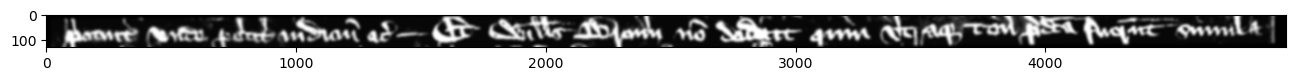

In [10]:
plt.figure(figsize=(16,6))
idx = 10
print(torch.min(train_dataset[idx]["image"]), torch.max(train_dataset[idx]["image"]))
plt.imshow(train_dataset[idx]["image"][0], cmap="gray")

In [11]:
train_loader = utils.data.DataLoader(train_dataset, num_workers=4)
valid_loader = utils.data.DataLoader(val_dataset, num_workers=4)

In [12]:
trainer = L.Trainer(accumulate_grad_batches=1, max_epochs=250, enable_progress_bar=True)
trainer.fit(transcriber, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | net  | MyTransformer | 8.9 M 
---------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.638    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/stanley/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch, accuracy: 0 0.012


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 0 0.2669


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 1 0.2778


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 2 0.2959


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 3 0.3053


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 4 0.3227


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 5 0.3315


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 6 0.3472


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 7 0.3688


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 8 0.3915


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 9 0.407


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 10 0.4232


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 11 0.4294


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 12 0.4427


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 13 0.4507


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 14 0.4611


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 15 0.4711


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 16 0.4828


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 17 0.4849


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 18 0.4946


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 19 0.5002


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 20 0.5045


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 21 0.3755


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 22 0.5162


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 23 0.5205


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 24 0.5243


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 25 0.5293


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 26 0.5305


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 27 0.5257


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 28 0.5404


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 29 0.5408


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 30 0.5265


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 31 0.5191


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 32 0.4797


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 33 0.4781


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 34 0.401


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 35 0.4774


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 36 0.4148


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 37 0.521


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 38 0.466


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 39 0.3946


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 40 0.5448


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 41 0.4706


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 42 0.5165


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 43 0.5238


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 44 0.4907


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 45 0.448


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 46 0.3924


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 47 0.4307


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 48 0.5495


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 49 0.5187


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 50 0.4944


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 51 0.3938


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 52 0.403


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 53 0.4391


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 54 0.5119


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 55 0.4979


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 56 0.5493


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 57 0.4574


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 58 0.4152


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 59 0.4573


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 60 0.4559


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 61 0.4733


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 62 0.4609


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 63 0.4035


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 64 0.4443


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 65 0.3989


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 66 0.3868


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 67 0.4136


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 68 0.3998


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 69 0.5222


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 70 0.5141


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 71 0.5071


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 72 0.4943


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 73 0.491


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 74 0.4839


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 75 0.484


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 76 0.461


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 77 0.4995


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 78 0.5109


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 79 0.4895


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 80 0.4627


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 81 0.4927


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 82 0.5212


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 83 0.4968


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 84 0.4874


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 85 0.4805


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 86 0.4805


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 87 0.5045


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 88 0.499


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 89 0.498


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 90 0.512


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 91 0.5095


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 92 0.4955


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 93 0.4975


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 94 0.4856


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 95 0.4778


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 96 0.4794


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 97 0.477


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 98 0.4587


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 99 0.4837


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 100 0.4958


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 101 0.4732


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 102 0.4893


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 103 0.4925


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 104 0.5016


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 105 0.4997


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 106 0.4945


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 107 0.4981


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 108 0.4815


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 109 0.478


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 110 0.4843


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 111 0.4879


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 112 0.4845


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 113 0.4933


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 114 0.5075


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 115 0.5121


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 116 0.5159


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 117 0.5063


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 118 0.4909


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 119 0.4963


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 120 0.4841


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 121 0.4929


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 122 0.4836


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 123 0.4956


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 124 0.4817


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 125 0.4796


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 126 0.4866


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 127 0.4739


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 128 0.4958


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 129 0.4761


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 130 0.4852


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 131 0.4644


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 132 0.4724


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 133 0.472


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 134 0.4707


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 135 0.4764


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 136 0.4751


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 137 0.5067


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 138 0.5013


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 139 0.4807


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 140 0.5092


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 141 0.5001


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 142 0.5052


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 143 0.4959


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 144 0.4846


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 145 0.4825


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 146 0.4823


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 147 0.4806


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 148 0.4818


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 149 0.5184


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 150 0.5076


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 151 0.5195


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 152 0.5095


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 153 0.5088


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 154 0.504


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 155 0.5108


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 156 0.5033


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 157 0.5109


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 158 0.5022


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 159 0.4896


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 160 0.486


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 161 0.496


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 162 0.4717


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 163 0.487


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 164 0.4802


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 165 0.4631


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 166 0.4455


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 167 0.4505


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 168 0.4601


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 169 0.4467


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 170 0.4635


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 171 0.4499


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 172 0.4948


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 173 0.4839


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 174 0.4784


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 175 0.4604


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 176 0.4638


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 177 0.463


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 178 0.4528


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 179 0.4491


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 180 0.4684


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 181 0.462


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 182 0.4803


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 183 0.4801


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 184 0.4764


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 185 0.4815


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 186 0.4693


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 187 0.4683


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 188 0.4776


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 189 0.4772


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 190 0.4655


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 191 0.4891


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 192 0.4892


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 193 0.5059


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 194 0.4728


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 195 0.4699


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 196 0.4788


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 197 0.4739


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 198 0.4569


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 199 0.4707


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 200 0.4811


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 201 0.4628


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 202 0.4667


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 203 0.4718


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 204 0.478


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 205 0.4712


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 206 0.4759


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 207 0.4596


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 208 0.4689


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 209 0.4626


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 210 0.4603


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 211 0.4546


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 212 0.4775


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 213 0.4814


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 214 0.4771


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 215 0.4695


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 216 0.4762


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 217 0.4928


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 218 0.4952


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 219 0.4782


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 220 0.4542


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 221 0.4482


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 222 0.4532


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 223 0.4539


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 224 0.4527


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 225 0.4566


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 226 0.4482


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 227 0.4736


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 228 0.4844


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 229 0.4834


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 230 0.492


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 231 0.472


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 232 0.4886


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 233 0.4765


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 234 0.4701


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 235 0.4762


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 236 0.4814


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 237 0.4697


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 238 0.4729


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 239 0.4447


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 240 0.4751


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 241 0.4572


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 242 0.4367


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 243 0.4621


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 244 0.4775


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 245 0.4765


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 246 0.4511


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 247 0.4546


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 248 0.4549


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch, accuracy: 249 0.463


In [13]:
trainer.validate(ckpt_path="best", dataloaders=valid_loader)

Restoring states from the checkpoint path at /home/stanley/latin_documents/lightning_logs/version_25/checkpoints/epoch=249-step=252250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/stanley/latin_documents/lightning_logs/version_25/checkpoints/epoch=249-step=252250.ckpt


Validation: 0it [00:00, ?it/s]

Epoch, accuracy: 250 0.463


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.46302543944424923    │
│        val_avg_acc        │    0.46302545070648193    │
│         val_loss          │    1.9645569324493408     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.9645569324493408,
  'val_acc': 0.46302543944424923,
  'val_avg_acc': 0.46302545070648193}]